[Data](http://www.thumos.info/download.html)

In [11]:
import torch
import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_video
from torchvision.transforms import ToTensor, Lambda

class CustomVideoDataset(Dataset):
    def __init__(self, vid_dir, transform=None, target_transform=None):
        self.vid_labels = os.listdir(vid_dir)
        self.vid_dir = vid_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.vid_labels)

    def __getitem__(self, idx):
        vid_path = os.path.join(self.vid_dir, self.vid_labels[idx])
        video = read_video(vid_path, pts_unit='sec')[0]
        label = self.vid_labels[idx]
        if self.transform:
            video = self.transform(video)
        if self.target_transform:
            label = self.target_transform(annotationToNum(label.split("_")[1]))
        return video, label

annotation_list = ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress', 'Biking', 'Billiards', 'BlowDryHair', 'BlowingCandles', 'BodyWeightSquats', 'Bowling', 'BoxingPunchingBag', 'BoxingSpeedBag', 'BreastStroke', 'BrushingTeeth', 'CleanAndJerk', 'CliffDiving', 'CricketBowling', 'CricketShot', 'CuttingInKitchen', 'Diving', 'Drumming', 'Fencing', 'FieldHockeyPenalty', 'FloorGymnastics', 'FrisbeeCatch', 'FrontCrawl', 'GolfSwing', 'Haircut', 'Hammering', 'HammerThrow', 'HandstandPushups', 'HandstandWalking', 'HeadMassage', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop', 'IceDancing', 'JavelinThrow', 'JugglingBalls', 'JumpingJack', 'JumpRope', 'Kayaking', 'Knitting', 'LongJump', 'Lunges', 'MilitaryParade', 'Mixing', 'MoppingFloor', 'Nunchucks', 'ParallelBars', 'PizzaTossing', 'PlayingCello', 'PlayingDaf', 'PlayingDhol', 'PlayingFlute', 'PlayingGuitar', 'PlayingPiano', 'PlayingSitar', 'PlayingTabla', 'PlayingViolin', 'PoleVault', 'PommelHorse', 'PullUps', 'Punch', 'PushUps', 'Rafting', 'RockClimbingIndoor', 'RopeClimbing', 'Rowing', 'SalsaSpin', 'ShavingBeard', 'Shotput', 'SkateBoarding', 'Skiing', 'Skijet', 'SkyDiving', 'SoccerJuggling', 'SoccerPenalty', 'StillRings', 'SumoWrestling', 'Surfing', 'Swing', 'TableTennisShot', 'TaiChi', 'TennisSwing', 'ThrowDiscus', 'TrampolineJumping', 'Typing', 'UnevenBars', 'VolleyballSpiking', 'WalkingWithDog', 'WallPushups', 'WritingOnBoard', 'YoYo']

def annotationToNum(annotation):
    return annotation_list.index(annotation)

def numToAnnotation(num):
    return annotation_list[num]

vid_dir = "C://Users//menez//Documents//VSCode//MLPlayground//VideoClassification//data//UCF101_videos//UCF101"

In [12]:
training_data = CustomVideoDataset(vid_dir, target_transform=Lambda(lambda y: torch.zeros(101, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

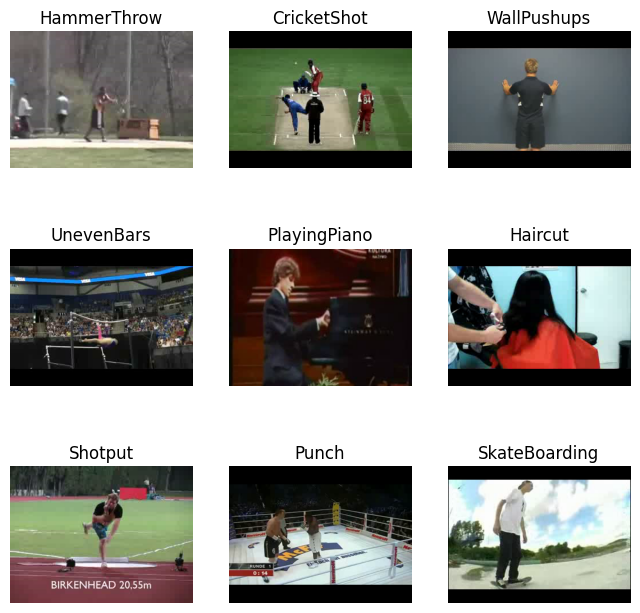

In [13]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    video, label = training_data[sample_idx]
    img = video[0]
    label = numToAnnotation(label.argmax().item())
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

[SlowFast Model](https://pytorch.org/hub/facebookresearch_pytorchvideo_slowfast/)

In [14]:
import torch
import json
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)
from typing import Dict

# Device on which to run the model
# Set to cuda to load on GPU
device = "cpu"

# Pick a pretrained model and load the pretrained weights
model_name = "slowfast_r50"
model = torch.hub.load("facebookresearch/pytorchvideo", model=model_name, pretrained=True)

# Set to eval mode and move to desired device
model = model.to(device)
model = model.eval()

Using cache found in C:\Users\menez/.cache\torch\hub\facebookresearch_pytorchvideo_main


In [15]:
with open("data/kinetics_classnames.json", "r") as f:
    kinetics_classnames = json.load(f)

# Create an id to label name mapping
kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

In [16]:
####################
# SlowFast transform
####################

side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 2
frames_per_second = 30
alpha = 4

class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors.
    """
    def __init__(self):
        super().__init__()

    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)

# The duration of the input clip is also specific to the model.
clip_duration = (num_frames * sampling_rate)/frames_per_second

SlowFast Inference

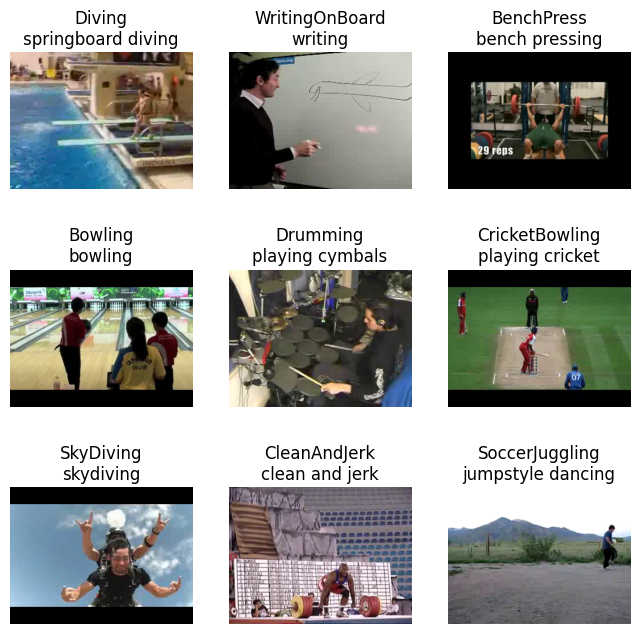

In [17]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    video, realLabel = training_data[sample_idx]
    img = video[0]
    realLabel = numToAnnotation(realLabel.argmax().item())

    uri = training_data.vid_labels[sample_idx]
    label = uri.split("_")[1]    

    # Load the example video
    video_path = vid_dir + "//" + uri

    # Select the duration of the clip to load by specifying the start and end duration
    # The start_sec should correspond to where the action occurs in the video
    start_sec = 0
    end_sec = start_sec + clip_duration

    # Initialize an EncodedVideo helper class
    video = EncodedVideo.from_path(video_path)

    # Load the desired clip
    video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)

    # Apply a transform to normalize the video input
    video_data = transform(video_data)

    # Move the inputs to the desired device
    inputs = video_data["video"]
    inputs = [i.to(device)[None, ...] for i in inputs]

    # Pass the input clip through the model
    preds = model(inputs)

    # Get the predicted classes
    post_act = torch.nn.Softmax(dim=1)
    preds = post_act(preds)
    pred_classes = preds.topk(k=1).indices

    # Map the predicted classes to the label names
    pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes[0]]
    # print("Predicted labels: %s" % ", ".join(pred_class_names))

    label = realLabel + "\n" + pred_class_names[0]

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

[3D Resnet Model](https://pytorch.org/hub/facebookresearch_pytorchvideo_resnet/)

In [18]:
import torch
# Choose the `slow_r50` model 
model = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50', pretrained=True)

Using cache found in C:\Users\menez/.cache\torch\hub\facebookresearch_pytorchvideo_main


In [19]:
import json
import urllib
from pytorchvideo.data.encoded_video import EncodedVideo

from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample
)

# Set to GPU or CPU
device = "cpu"
model = model.eval()
model = model.to(device)

In [20]:
####################
# Slow transform
####################

side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 8
sampling_rate = 8
frames_per_second = 30

# Note that this transform is specific to the slow_R50 model.
transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size=(crop_size, crop_size))
        ]
    ),
)

# The duration of the input clip is also specific to the model.
clip_duration = (num_frames * sampling_rate)/frames_per_second

Slow Inference

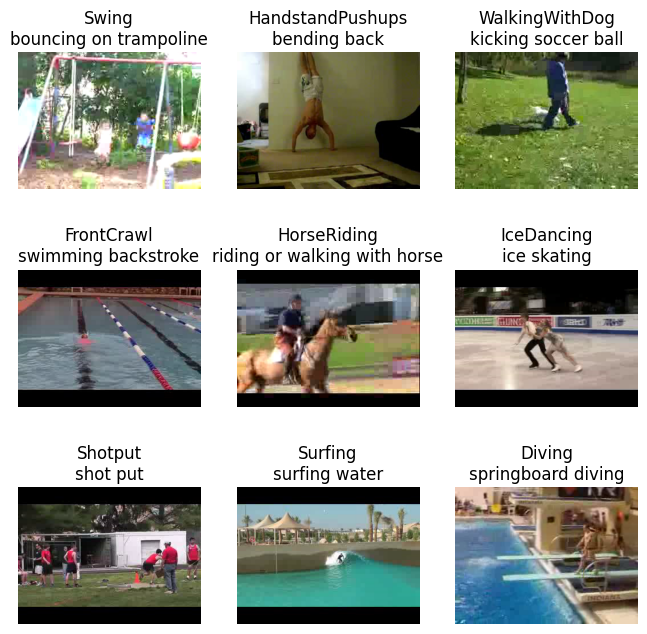

In [21]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    video, realLabel = training_data[sample_idx]
    img = video[0]
    realLabel = numToAnnotation(realLabel.argmax().item())

    uri = training_data.vid_labels[sample_idx]
    label = uri.split("_")[1]    

    # Load the example video
    video_path = vid_dir + "//" + uri

    # Select the duration of the clip to load by specifying the start and end duration
    # The start_sec should correspond to where the action occurs in the video
    start_sec = 0
    end_sec = start_sec + clip_duration

    # Initialize an EncodedVideo helper class
    video = EncodedVideo.from_path(video_path)

    # Load the desired clip
    video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)

    # Apply a transform to normalize the video input
    video_data = transform(video_data)

    # Move the inputs to the desired device
    inputs = video_data["video"]
    inputs = inputs.to(device)

    # Pass the input clip through the model
    preds = model(inputs[None, ...])

    # Get the predicted classes
    post_act = torch.nn.Softmax(dim=1)
    preds = post_act(preds)
    pred_classes = preds.topk(k=1).indices

    # Map the predicted classes to the label names
    pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes[0]]
    # print("Predicted labels: %s" % ", ".join(pred_class_names))

    label = realLabel + "\n" + pred_class_names[0]

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

[X3D Model](https://pytorch.org/hub/facebookresearch_pytorchvideo_x3d/)

In [22]:
import torch
# Choose the `x3d_s` model
model_name = 'x3d_s'
model = torch.hub.load('facebookresearch/pytorchvideo', model_name, pretrained=True)

Using cache found in C:\Users\menez/.cache\torch\hub\facebookresearch_pytorchvideo_main


In [23]:
import json
import urllib
from pytorchvideo.data.encoded_video import EncodedVideo

from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample
)

# Set to GPU or CPU
device = "cpu"
model = model.eval()
model = model.to(device)

In [24]:
####################
# X3D transform
####################

mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
frames_per_second = 30
model_transform_params  = {
    "x3d_xs": {
        "side_size": 182,
        "crop_size": 182,
        "num_frames": 4,
        "sampling_rate": 12,
    },
    "x3d_s": {
        "side_size": 182,
        "crop_size": 182,
        "num_frames": 13,
        "sampling_rate": 6,
    },
    "x3d_m": {
        "side_size": 256,
        "crop_size": 256,
        "num_frames": 16,
        "sampling_rate": 5,
    }
}

# Get transform parameters based on model
transform_params = model_transform_params[model_name]

# Note that this transform is specific to the slow_R50 model.
transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(transform_params["num_frames"]),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(size=transform_params["side_size"]),
            CenterCropVideo(
                crop_size=(transform_params["crop_size"], transform_params["crop_size"])
            )
        ]
    ),
)

# The duration of the input clip is also specific to the model.
clip_duration = (transform_params["num_frames"] * transform_params["sampling_rate"])/frames_per_second

X3D Inference

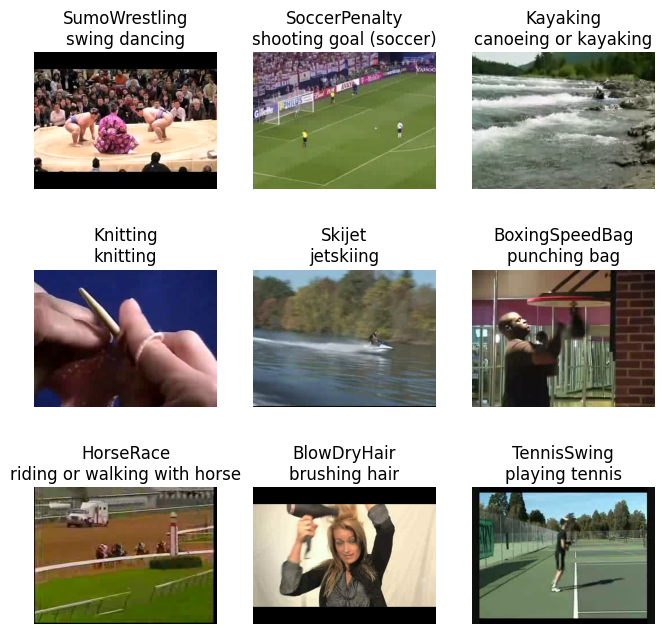

In [25]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    video, realLabel = training_data[sample_idx]
    img = video[0]
    realLabel = numToAnnotation(realLabel.argmax().item())

    uri = training_data.vid_labels[sample_idx]
    label = uri.split("_")[1]    

    # Load the example video
    video_path = vid_dir + "//" + uri

    # Select the duration of the clip to load by specifying the start and end duration
    # The start_sec should correspond to where the action occurs in the video
    start_sec = 0
    end_sec = start_sec + clip_duration

    # Initialize an EncodedVideo helper class
    video = EncodedVideo.from_path(video_path)

    # Load the desired clip
    video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)

    # Apply a transform to normalize the video input
    video_data = transform(video_data)

    # Move the inputs to the desired device
    inputs = video_data["video"]
    inputs = inputs.to(device)

    # Pass the input clip through the model
    preds = model(inputs[None, ...])

    # Get the predicted classes
    post_act = torch.nn.Softmax(dim=1)
    preds = post_act(preds)
    pred_classes = preds.topk(k=1).indices

    # Map the predicted classes to the label names
    pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes[0]]
    # print("Predicted labels: %s" % ", ".join(pred_class_names))

    label = realLabel + "\n" + pred_class_names[0]

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()